# Parkinson's disease linear classification by logistic regression

## This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD.

## https://archive.ics.uci.edu/ml/datasets/Parkinsons

In [1]:
import matplotlib.pyplot as plt
import math
from mlxtend.plotting import plot_decision_regions
import numpy as np
from numpy import percentile
from numpy.random import seed
import os
import pandas as pd
from sqlalchemy import create_engine
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_folder = r'C:\Users\user\OneDrive - Seedergy\MAEN\Code\Projects\Courses\Thinkful2020'
data_file = os.path.join(base_folder,'parkinsons' + "." + 'data')
df_data = pd.read_csv(data_file) 

## Explore the data

In [3]:
nRow, nCol = df_data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 195 rows and 24 columns


In [4]:
df_data.head(3)

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634


In [5]:
df_data = df_data.drop(['name'], axis=1)

In [6]:
# Help functions to gather basic descriptions
def describe(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mean abs dev'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                      df.nunique().rename('unique')
                     ], axis=1).T

In [ ]:
# Non-numerical describe
df_stat = df_data.describe(include = ['O']) 
df_stat.loc['dtype'] = df_data.dtypes
df_stat.loc['size'] = len(df_data)
df_stat.loc['% null'] = df_data.isnull().mean().round(2)
df_stat

In [7]:
# Numerical describe
df_stat = df_data.describe(include = [np.number]) 
df_stat.loc['dtype'] = df_data.dtypes
df_stat.loc['size'] = len(df_data)
df_stat.loc['% null'] = df_data.isnull().mean().round(2)
df_stat

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195,195,195,195,195,195,195,195,195,195,...,195,195,195,195,195,195,195,195,195,195
mean,154.229,197.105,116.325,0.00622046,4.3959e-05,0.00330641,0.00344636,0.00991995,0.0297091,0.282251,...,0.0469926,0.0248471,21.886,0.753846,0.498536,0.718099,-5.6844,0.22651,2.38183,0.206552
std,41.3901,91.4915,43.5214,0.00484813,3.48219e-05,0.00296777,0.00275898,0.00890334,0.0188569,0.194877,...,0.0304591,0.0404184,4.42576,0.431878,0.103942,0.0553358,1.09021,0.0834058,0.382799,0.0901193
min,88.333,102.145,65.476,0.00168,7e-06,0.00068,0.00092,0.00204,0.00954,0.085,...,0.01364,0.00065,8.441,0,0.25657,0.574282,-7.96498,0.006274,1.42329,0.044539
25%,117.572,134.863,84.291,0.00346,2e-05,0.00166,0.00186,0.004985,0.016505,0.1485,...,0.024735,0.005925,19.198,1,0.421306,0.674758,-6.4501,0.174351,2.09913,0.137451
50%,148.79,175.829,104.315,0.00494,3e-05,0.0025,0.00269,0.00749,0.02297,0.221,...,0.03836,0.01166,22.085,1,0.495954,0.722254,-5.72087,0.218885,2.36153,0.194052
75%,182.769,224.206,140.019,0.007365,6e-05,0.003835,0.003955,0.011505,0.037885,0.35,...,0.060795,0.02564,25.0755,1,0.587562,0.761881,-5.04619,0.279234,2.63646,0.25298
max,260.105,592.03,239.17,0.03316,0.00026,0.02144,0.01958,0.06433,0.11908,1.302,...,0.16942,0.31482,33.047,1,0.685151,0.825288,-2.43403,0.450493,3.67116,0.527367
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
size,195,195,195,195,195,195,195,195,195,195,...,195,195,195,195,195,195,195,195,195,195


In [8]:
# Remove status from the list of columnsnames
names = df_data.columns
names = [x for x in names if x != 'status']

In [9]:
X = df_data.loc[:, names]
y = df_data.loc[:, 'status']

In [10]:
X.head(2)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674


In [11]:
y.head(2)

0    1
1    1
Name: status, dtype: int64

## Split the data into training and test and fit the model

### Try some tuning and see impact on the accuracy

In [16]:
# Default setting with no penalty
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr_regularized = LogisticRegression(solver='lbfgs', penalty='none', random_state=2)
lr_regularized.fit(X_train, y_train)

lr_regularized.score(X_test, y_test)

test_score = lr_regularized.score(X_test, y_test)
train_score = lr_regularized.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.8692307692307693
Score on test data:  0.8307692307692308


In [14]:
# Increading iteration from 100 in default to 1000
lr_regularized = LogisticRegression(solver='lbfgs', penalty='none', max_iter=1000, random_state=2)
lr_regularized.fit(X_train, y_train)

lr_regularized.score(X_test, y_test)

test_score = lr_regularized.score(X_test, y_test)
train_score = lr_regularized.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.8923076923076924
Score on test data:  0.8307692307692308


In [17]:
# Increading iteration from 100 in default to 1000 and choose l2 as the cost function
lr_regularized = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, random_state=2)
lr_regularized.fit(X_train, y_train)

lr_regularized.score(X_test, y_test)

test_score = lr_regularized.score(X_test, y_test)
train_score = lr_regularized.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.8692307692307693
Score on test data:  0.8307692307692308


### Above tunining did not have any impact on the accuracy and next we dig deeper

## Regularization

### We have overfitting problem when the model become too specific to the training data and does not generalize to previously unseen data. Here we compare two models side by side to see the impact of regularization

In [18]:
# Increading iteration from 100 in default to 1000
lr = LogisticRegression(solver='lbfgs', penalty='none', max_iter=1000, random_state=2)
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

test_score = lr.score(X_test, y_test)
train_score = lr.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.8923076923076924
Score on test data:  0.8307692307692308


In [19]:
# Increading iteration from 100 in default to 1000
lr_regularized = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, random_state=2)
lr_regularized.fit(X_train, y_train)

lr_regularized.score(X_test, y_test)

test_score = lr_regularized.score(X_test, y_test)
train_score = lr_regularized.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.8692307692307693
Score on test data:  0.8307692307692308


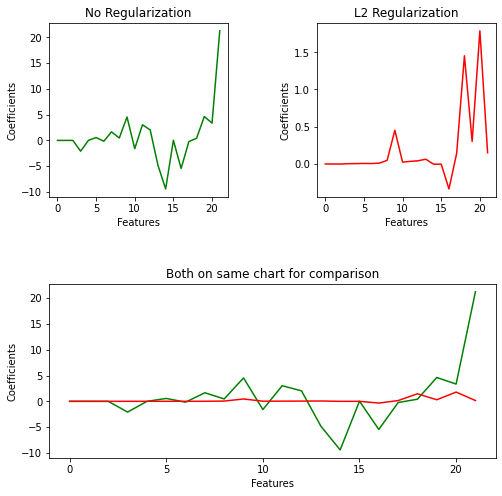

In [20]:
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.5)


x = np.arange(0, len(lr.coef_[0]),1)
y = lr.coef_[0]
ax1 = fig.add_subplot(grid[0, 0])
ax1.plot(x, y, '-g')
ax1.set(xlabel='Features', ylabel='Coefficients')
ax1.set_title('No Regularization')

y_reg = lr_regularized.coef_[0]
ax2 = fig.add_subplot(grid[0, 1])
ax2.plot(x, y_reg, '-r')
ax2.set(xlabel='Features', ylabel='Coefficients')
ax2.set_title('L2 Regularization')

ax3 = fig.add_subplot(grid[1, 0:])
ax3.plot(x, y, '-g')
ax3.plot(x, y_reg, '-r')

ax3.set(xlabel='Features', ylabel='Coefficients')
ax3.set_title('Both on same chart for comparison')
plt.show()

### The value range with regularization is between 0 and 1.5 while without it is between -10 and 20. Another available tuning parametre is the value of C which is an inverse regularization strength, meaning that lower values of C cause stronger regulatization. However, choosing a property value for C is tricky and we have to find one with trial and error. Following with try logistic regression with different values of C.

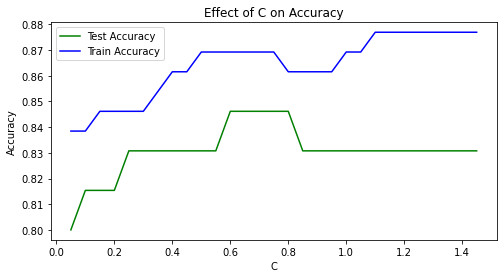

In [21]:
c_vals = np.arange(0.05, 1.5, 0.05)
test_accuracy = []
train_accuracy = []

for c in c_vals:
  lr = LogisticRegression(solver='lbfgs', penalty='l2', C=c, max_iter=10000, random_state=2)
  lr.fit(X_train, y_train)
  test_accuracy.append(lr.score(X_test, y_test))
  train_accuracy.append(lr.score(X_train, y_train))

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(c_vals, test_accuracy, '-g', label='Test Accuracy')
ax1.plot(c_vals, train_accuracy, '-b', label='Train Accuracy')
ax1.set(xlabel='C', ylabel='Accuracy')
ax1.set_title('Effect of C on Accuracy')
ax1.legend()
plt.show()

### We get the best accuracy around C = 0.8 where the distance between Test Accuracy and Train Accuracy is minimum.

## Try different solver than 'lbfgs'

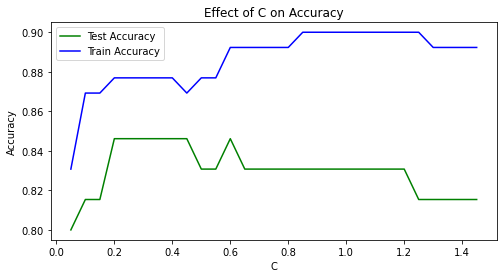

In [22]:
c_vals = np.arange(0.05, 1.5, 0.05)
test_accuracy = []
train_accuracy = []

for c in c_vals:
  lr = LogisticRegression(solver='liblinear', penalty='l2', C=c, max_iter=10000, random_state=2)
  lr.fit(X_train, y_train)
  test_accuracy.append(lr.score(X_test, y_test))
  train_accuracy.append(lr.score(X_train, y_train))

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(c_vals, test_accuracy, '-g', label='Test Accuracy')
ax1.plot(c_vals, train_accuracy, '-b', label='Train Accuracy')
ax1.set(xlabel='C', ylabel='Accuracy')
ax1.set_title('Effect of C on Accuracy')
ax1.legend()
plt.show()

### We get the best accuracy around C = 0.1 where the distance between Test Accuracy and Train Accuracy is minimum.

## We have one final optimization which is about making the scale of all features approximately similar.

In [23]:
df_data.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


### We can see some features have very different scales and we will use standard scalare for these features

In [24]:
# Remove status from the list of columnsnames
names = df_data.columns
names = [x for x in names if x != 'status']

In [25]:
X = df_data.loc[:, names]
y = df_data.loc[:, 'status']

In [26]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
data_df_scaled = pd.DataFrame(scaled_data, columns = X.columns)#, columns=breast_cancer.feature_names)

data_df_scaled.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
count,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,...,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,195.000000
mean,2.960595e-17,-2.277381e-16,1.047595e-16,1.821904e-17,2.732857e-17,-1.275333e-16,7.287618e-17,5.465713e-17,2.493732e-16,-1.639714e-16,...,-9.564998e-17,-1.540079e-16,9.109522e-17,8.198570e-16,-8.198570e-17,5.830094e-16,1.184238e-15,-1.275333e-16,-5.830094e-16,0.000000
std,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,...,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574
min,-1.596162e+00,-1.040581e+00,-1.171366e+00,-9.389487e-01,-1.064103e+00,-8.872543e-01,-9.180440e-01,-8.873331e-01,-1.072340e+00,-1.014787e+00,...,-9.993055e-01,-1.097815e+00,-6.002051e-01,-3.045707e+00,-2.333888e+00,-2.605676e+00,-2.097268e+00,-2.647338e+00,-2.510472e+00,-1.802384
25%,-8.879183e-01,-6.820590e-01,-7.379376e-01,-5.708520e-01,-6.898141e-01,-5.561906e-01,-5.764609e-01,-5.557071e-01,-7.020291e-01,-6.881025e-01,...,-6.508513e-01,-7.326182e-01,-4.693595e-01,-6.089102e-01,-7.449206e-01,-7.852617e-01,-7.041503e-01,-6.269844e-01,-7.404100e-01,-0.768742
50%,-1.317379e-01,-2.331437e-01,-2.766579e-01,-2.647942e-01,-4.018994e-01,-2.724216e-01,-2.748504e-01,-2.736279e-01,-3.583019e-01,-3.151160e-01,...,-3.444009e-01,-2.841460e-01,-3.271036e-01,4.508553e-02,-2.490033e-02,7.527941e-02,-3.353960e-02,-9.166005e-02,-5.315145e-02,-0.139058
75%,6.913210e-01,2.969710e-01,5.458200e-01,2.366858e-01,4.618447e-01,1.785683e-01,1.848331e-01,1.784870e-01,4.346898e-01,3.485429e-01,...,3.146448e-01,4.543110e-01,1.966835e-02,7.225273e-01,8.587132e-01,7.932500e-01,5.869042e-01,6.337615e-01,6.668912e-01,0.516514
max,2.564598e+00,4.327631e+00,2.829908e+00,5.570985e+00,6.220139e+00,6.125892e+00,5.862742e+00,6.126923e+00,4.751617e+00,5.246243e+00,...,6.726438e+00,4.029746e+00,7.192738e+00,2.528321e+00,1.800007e+00,1.942048e+00,2.989093e+00,2.692370e+00,3.376831e+00,3.569059


### Now each feature is roughly the same scale. And we train the Logistic Regression model on this new data set

In [27]:
result = pd.concat([data_df_scaled, y], axis=1).reindex(data_df_scaled.index)

In [28]:
X = result.loc[:, names]
y = result.loc[:, 'status']

In [29]:
result.head(2)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,-0.829300,-0.436165,-0.952037,0.334914,0.749759,0.132963,0.760800,0.131755,0.745985,0.739536,...,0.607532,-0.067893,-0.193225,-0.807838,1.760814,0.801323,0.480477,-0.210531,0.868886,1
1,-0.770972,-0.530974,-0.057721,0.715418,1.037674,0.453892,1.276809,0.452684,1.681731,1.768464,...,1.548254,-0.137843,-0.634508,-0.387524,1.837562,1.479853,1.311185,0.275077,1.803605,1


In [30]:
y.head(2)

0    1
1    1
Name: status, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr_regularized = LogisticRegression(solver='lbfgs', penalty='none', random_state=2)
lr_regularized.fit(X_train, y_train)

lr_regularized.score(X_test, y_test)

test_score = lr_regularized.score(X_test, y_test)
train_score = lr_regularized.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.9076923076923077
Score on test data:  0.8307692307692308


## Still no impact on accuracy